# Задание:
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход, принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [ ]:
# загружаем необходимые библиотеки (а по факту все, что были на семинаре)
from scipy import stats
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
# загружаем файл и смотрим на таблицу в первом приближении
data = pd.read_excel('AB_Test_Results (2).xlsx')
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [3]:
# смотрим сводную информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Как видно из сводной инфы: целостность таблицы не нарушена - все столбцы заполнены по всем 10 000 строкам, типы данных корректные.

In [6]:
# зачем-то смотрим размерность таблицы еще и этим методом (возможно, чтобы мы его изучили - чтож, коварный план удался)
data.shape

(10000, 3)

In [7]:
# ну и еще одна проверка
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Что-то меня немного "напрягает", что стандартное отклонение не сильно коррелируется со средним значением всей выборки. Если среднее минус отклонение, то уйдем в минуса. Но! Минимальное значение не падает ниже нуля, и наверно данные можно считать "чистыми".

В задании нам говорят о метрике продаж, а сама таблица не "балует" данными. Следовательно, берем две группы по VARIANT_NAME.

In [8]:
data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


In [9]:
data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


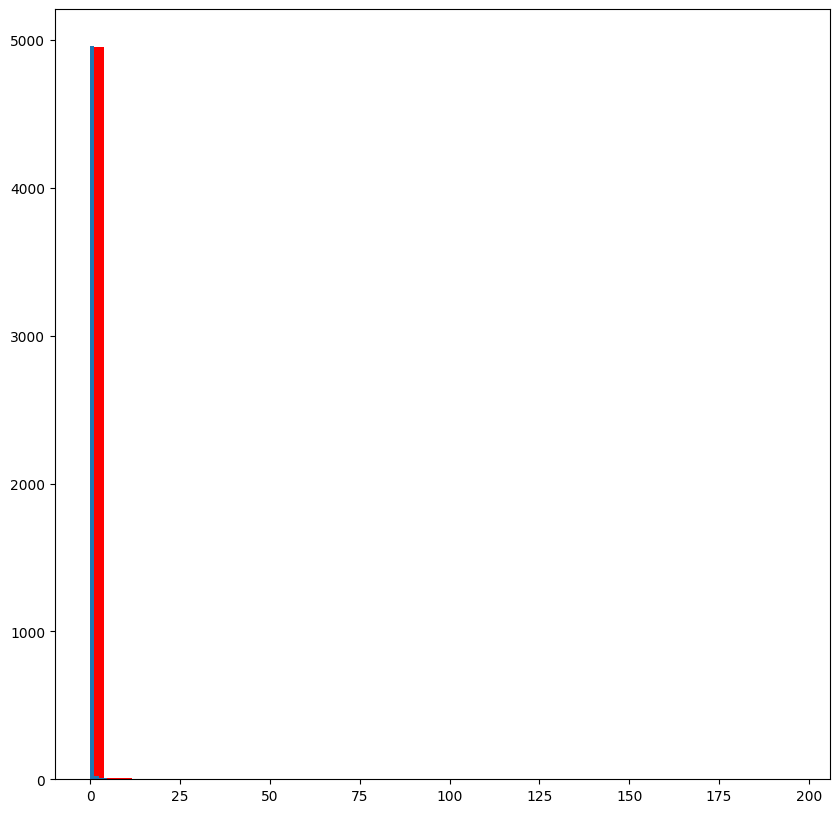

In [11]:
plt.figure(figsize=(10, 10))
control_revenue = data['REVENUE'][data['VARIANT_NAME'] == 'control']
variant_revenue = data['REVENUE'][data['VARIANT_NAME'] == 'variant']


plt.hist(control_revenue, color='r', bins=50)
plt.hist(variant_revenue,  bins=50)


plt.show()

Мне одному кажется, что на графике видна какая-то "фигня"? Придумал убрать из выборки все строки, где значения покупок равна нулю.

In [12]:
data = data[(data['REVENUE'] != 0)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 13 to 9977
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       152 non-null    int64  
 1   VARIANT_NAME  152 non-null    object 
 2   REVENUE       152 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB


Остались крохи, попробуем построить график на них.

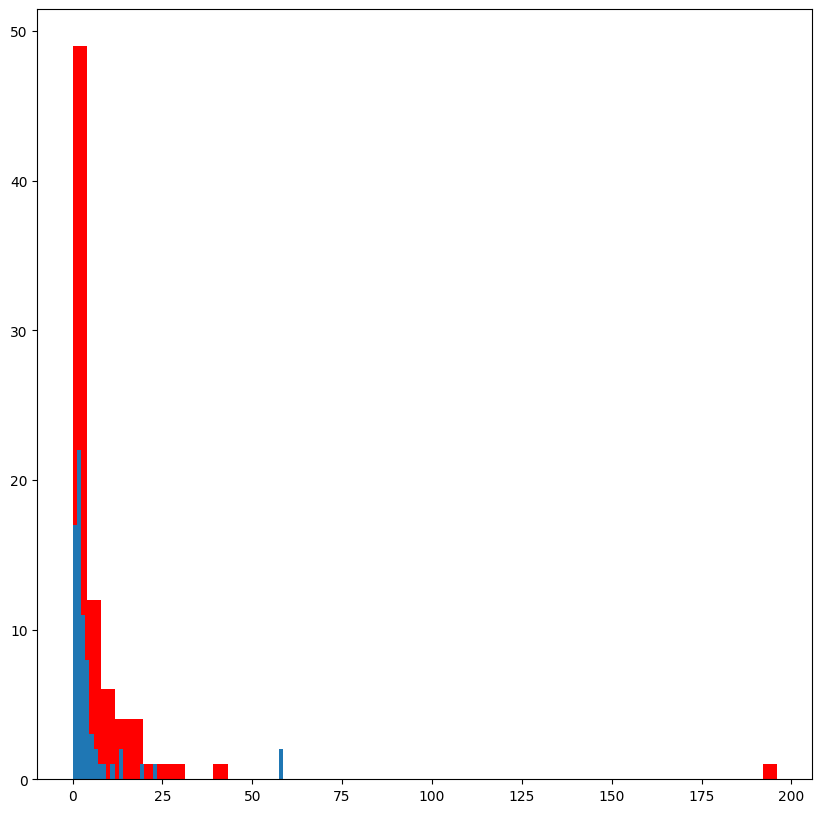

In [13]:
plt.figure(figsize=(10, 10))
control_revenue = data['REVENUE'][data['VARIANT_NAME'] == 'control']
variant_revenue = data['REVENUE'][data['VARIANT_NAME'] == 'variant']


plt.hist(control_revenue, color='r', bins=50)
plt.hist(variant_revenue,  bins=50)


plt.show()

По графику конечно видно, что распределение не нормальное, но надо же проверить еще тестиком. Пойду как на лекции/семинаре - через t-тест.

In [14]:
stats.ttest_ind(control_revenue, variant_revenue, equal_var = False)

Ttest_indResult(statistic=1.1379124979933528, pvalue=0.2576068539893233)

pvalue значительно больше уровня значимости 0,05. Т.о. подтверждаем, что распределение значений сумм покупок не является нормальным. Теперь надо подобрать тест для проверки гипотезы различий в группах "control" и "variant" - выбор среди непараметрических тестов. Имеет 2 группы сравнения и зависимые выборки. Выходит, что на нужен критерий Уилкоксона. Но с ним вышла ошибка, выборки групп разные по размерам - итого хи-квадрат спешит на помощь. Посчитаем для него значения:

In [21]:
data.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,80.0,8.037500,22.498124,0.02,1.515,2.96,6.6575,196.01
variant,72.0,4.881528,9.913973,0.02,1.245,2.17,3.9725,58.63


In [17]:
k1 = data[data['VARIANT_NAME']=='control']['REVENUE'].sum()
k2 = data[data['VARIANT_NAME']=='variant']['REVENUE'].sum()
k1, k2

(643.0, 351.47)

In [18]:
n1 = data[data['VARIANT_NAME']=='control'].shape[0]
n2 = data[data['VARIANT_NAME']=='variant'].shape[0]
n1, n2

(80, 72)

In [19]:
from statsmodels.stats import proportion
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]),
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =-10.408, pvalue = 1.000


In [20]:
if abs(pvalue) < 0.05:
    print("Мы можем отвергнуть нулевую гипотезу!")
else:
    print("Нам не удалось отвергнуть нулевую гипотезу")

Нам не удалось отвергнуть нулевую гипотезу


Насколько я понял, вывод: статистические различия между двумя выборками есть.
В качестве рекомендации надо писать: прибыль в варианте "control" выше.